# Inference Notebook

In [1]:
from IPython.core.debugger import set_trace
from glob import glob
import numpy as np

# Reading data coming from the pre-processing pipeline and creating both dancers
joint_poses = []
for file in glob('./data/*.npy'):
    interleaved_poses = np.load(file)
    poses_1 = interleaved_poses[0::2]
    poses_2 = interleaved_poses[1::2]

    # Sampling frames for movement smoothness
    joint_poses.append(np.concatenate((poses_1, poses_2), axis=1)[::3])
    print('Joint poses {} shape: {}\n'.format(file.split('/')[-1], joint_poses[-1].shape))

Joint poses pose_extraction_ilya_hannah_dyads.npy shape: (4520, 58, 3)

Joint poses pose_extraction_dyads_rehearsal_leah.npy shape: (7141, 58, 3)

Joint poses pose_extraction_img_9085.npy shape: (6406, 58, 3)

Joint poses pose_extraction_hannah_cassie.npy shape: (6522, 58, 3)



In [2]:
# Building initial transposed edge index (adjacencies)
edge_index_t = [[0, 1], [0, 2], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10], [7, 27], [8, 11],
                [8, 28], [9, 12], [9, 13], [9, 14], [12, 15], [13, 16], [14, 17], [15, 24], [16, 18], [17, 19],
                [18, 20], [19, 21], [20, 22], [21, 23], [22, 25], [23, 26]]

# Getting second person skeleton
n_joints = int(joint_poses[0].shape[1]/2)
init_skeleton_len = len(edge_index_t)
for edge_index in range(init_skeleton_len):
    edge_index_t.append([edge_index_t[edge_index][0]+n_joints, edge_index_t[edge_index][1]+n_joints])

# Saving skeletons for visualization
skeletons = edge_index_t.copy()

# Fully connecting the two people
for joint_1 in range(interleaved_poses.shape[1]):
    for joint_2 in range(interleaved_poses.shape[1]):
        edge_index_t.append([joint_1, joint_2+n_joints])

# Making graph undirected
full_skeleton_len = len(edge_index_t)
for edge_index in range(full_skeleton_len):
    edge_index_t.append([edge_index_t[edge_index][1], edge_index_t[edge_index][0]])

In [3]:
import torch
from utils import *

# Estimating velocity of points
frame_gap = 1
velocities = []
joint_poses_velo = []
for joint_pose in [joint_poses]:
    velocities_aux = []
    joint_poses_velo_aux = []
    
    for choreo in joint_pose:
        choreo = torch.Tensor(choreo)
    
        velocity_choreo = compute_velocities(choreo, frame_gap)
        velocities_aux.append(velocity_choreo)
        
        joint_poses_velo_aux.append(torch.cat((choreo, velocity_choreo), dim=-1))

    velocities.append(velocities_aux)
    joint_poses_velo.append(joint_poses_velo_aux)

In [4]:
seq_len = 8
batches = []
choreo_lens = []

# # Building non-overlapping sequences
# for joint_poses_rot_velo in joint_poses_velo:
#     for choreo in joint_poses_rot_velo:
#         choreo = torch.Tensor(choreo)
    
#         num_seqs = choreo.shape[0] // seq_len
#         batches.append(torch.stack([choreo[i*seq_len:(i+1)*seq_len] for i in range(num_seqs)]))
#         choreo_lens.append(batches[-1].size(0))

# Building overlapping sequences
for joint_poses_rot_velo in joint_poses_velo:
    for choreo in joint_poses_rot_velo:
        choreo = torch.Tensor(choreo)
    
        batches.append(torch.stack([choreo[i:i+seq_len] for i in range(len(choreo)-seq_len)]))
        choreo_lens.append(batches[-1].size(0))

batches = torch.cat(batches, dim=0)

# Fixing x, y, z configuration
batches[:, :, :, [0, 1, 2]] = batches[:, :, :, [2, 0, 1]]
batches[:, :, :, 2] = -batches[:, :, :, 2]

# Balanced training-validation split
train_split = []
val_split = []
train_batches = []
val_batches = []
next_choreo = 0
for choreo_len in choreo_lens:
    
    train_split.append(int(0.85*choreo_len))
    val_split.append(choreo_len - train_split[-1])
    
    train_batches.append(batches[next_choreo : next_choreo + train_split[-1]])
    val_batches.append(batches[next_choreo + train_split[-1] : next_choreo + choreo_len])
    
    next_choreo += choreo_len

train_batches = torch.cat(train_batches, dim=0)
val_batches = torch.cat(val_batches, dim=0)

# Printing all the data structures created
print('Shape of tensor with all sequences: {}'.format(batches.shape))
print('Length of each choreography: {}\n'.format(choreo_lens))

print('Shape of training data with all sequences: {}'.format(train_batches.shape))
print('Length of each choreography in training dataset: {}\n'.format(train_split))

print('Shape of validation data with all sequences: {}'.format(val_batches.shape))
print('Length of each choreography in validation dataset: {}\n'.format(val_split))

Shape of tensor with all sequences: torch.Size([24557, 8, 58, 6])
Length of each choreography: [4512, 7133, 6398, 6514]

Shape of training data with all sequences: torch.Size([20872, 8, 58, 6])
Length of each choreography in training dataset: [3835, 6063, 5438, 5536]

Shape of validation data with all sequences: torch.Size([3685, 8, 58, 6])
Length of each choreography in validation dataset: [677, 1070, 960, 978]



In [62]:
# Sampling dancers joints to simplify problem
sampled_joints_1 = [7, 10, 9]
sampled_joints_2 = [52, 31, 30]
sampled_joints = np.concatenate([sampled_joints_1, sampled_joints_2])
n_joints_sampled = len(sampled_joints)
print("Sampled joints for dancer 1: {}, and dancer 2: {}".format(sampled_joints_1, sampled_joints_2))

# Mapping sampled joints to new indices for the message passing matrices
edge_mapping = {e: c for c, e in zip(range(len(sampled_joints)), sampled_joints)}
inverse_edge_mapping = {c: e for c, e in zip(range(len(sampled_joints)), sampled_joints)}

sampled_batches = batches[:, :, sampled_joints, :]
sampled_train_batches = train_batches[:, :, sampled_joints, :]
sampled_val_batches = val_batches[:, :, sampled_joints, :]

print('Shape of sampled data with all sequences: {}'.format(sampled_batches.shape))
print('Shape of sampled training data with all sequences: {}'.format(sampled_train_batches.shape))
print('Shape of sampled validation data with all sequences: {}'.format(sampled_val_batches.shape))

sampled_edge_index_t = []
for (start, end) in edge_index_t[:len(edge_index_t)]:
    if (start not in sampled_joints) or (end not in sampled_joints):
        continue

    sampled_edge_index_t.append([edge_mapping[start], edge_mapping[end]])

Sampled joints for dancer 1: [7, 10, 9], and dancer 2: [52, 31, 30]
Shape of sampled data with all sequences: torch.Size([24557, 8, 6, 6])
Shape of sampled training data with all sequences: torch.Size([20872, 8, 6, 6])
Shape of sampled validation data with all sequences: torch.Size([3685, 8, 6, 6])


In [63]:
from modules import *

# Defining standard parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sampled_train_batches = sampled_train_batches.to(device)
sampled_val_batches = sampled_val_batches.to(device)
batch_size = seq_len

train_batches_cumsum = np.cumsum(np.array(train_split) // batch_size)
val_batches_cumsum = np.cumsum(np.array(val_split) // batch_size)

weights_path = 'best_weights/nri_parameters_param_grid_n-sample-dancers_3_dataset-multiplier_10_compact-encoder_True_recurrent-encoder_False_seq-len-in_8_seq-len-out_1_hidden-dim_64_edge-types_3_epochs_10_lr_0.0003_lr-cycle_5_loss-mode_mse.pt'

seq_len_in = seq_len
seq_len_out = 1
n_joints = sampled_batches.size(2)
dims = batches.size(3)

hidden_dim = int(weights_path.split('hidden-dim_')[1].split('_')[0])
edge_types = int(weights_path.split('edge-types_')[1].split('_')[0])
tau = 0.5
hard = True
dropout = 0.1
out_var = 5e-5

prior = [0.4, 0.3, 0.3]
log_prior = torch.FloatTensor(np.log(prior)).unsqueeze(0).unsqueeze(0).to(device)

compact_encoder = True if weights_path.split('compact-encoder_')[1].split('_')[0] == 'True' else False
recurrent_encoder = True if weights_path.split('recurrent-encoder_')[1].split('_')[0] == 'True' else False
recurrent_decoder = True

# Loading model
model = nri_vae(device, n_joints, sampled_edge_index_t, seq_len_in*dims, hidden_dim, edge_types, seq_len_out*int(dims/2), \
                tau, hard, dropout, dims, compact_encoder, recurrent_encoder, recurrent_decoder)

model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [64]:
# Choosing sequence based on the selected video and frame, and preparing n_joints for plotting
# choreo_idx = np.random.randint(len(joint_poses))
choreo_idx = 1
offset = 0
if choreo_idx != 0:
    offset = np.cumsum(train_split)[choreo_idx-1]

# frame = np.random.randint(joint_poses[choreo_idx].shape[0])
frame = 50
sequence = frame // seq_len_in

n_joints = int(sampled_batches.size(2)/2)

# Getting predicted edges from a sequence
logits = model.encoder(sampled_train_batches[offset + sequence].unsqueeze(0)).squeeze(0)

# Confidence threshold
confidence = 0.8
chosen_edge_type = -1
edge_index_classes = []
while len(edge_index_classes) <= 2:
    y = gumbel_softmax_sample(logits, tau, False)
    edge_index_classes = torch.where(y[:, chosen_edge_type] > confidence)[0]

# # Top % edges
# percentage = 0.01
# chosen_edge_type = -1
# k = int(len(edge_index_t)*percentage)
# edge_index_classes = torch.topk(y[:, chosen_edge_type], k)[1]

edge_index_samp = torch.Tensor(sampled_edge_index_t).to(device)[edge_index_classes].t().long()
print('Amount of edges sampled with confidence {}%: {}'.format(int(confidence*100), len(edge_index_classes)))
# print('Top {}% edges: {}'.format(int(percentage*100), len(edge_index_classes)))

# Getting reconstructed frame
decoder_m_in, decoder_m_out = message_passing_matrices(n_joints*2, edge_index_samp)
decoder_m_in = decoder_m_in.to(device)
decoder_m_out = decoder_m_out.to(device)

recon_list = []
for i in range(4*seq_len_in):
    recon_output = model.decoder(sampled_train_batches[offset + sequence], \
                                     edge_index_samp, decoder_m_in, decoder_m_out)
    recon_output = recon_output.view(seq_len_out, n_joints*2, int(dims/2)).cpu().detach().numpy()

    if seq_len_out == 1:
        recon_output = recon_output.squeeze(0)
        
    recon_list.append(recon_output)
    
edge_index_samp = torch.Tensor([[inverse_edge_mapping[e[0].item()], inverse_edge_mapping[e[1].item()]] for e in edge_index_samp.t().cpu().detach()]).to(device).t().long()

Amount of edges sampled with confidence 80%: 4


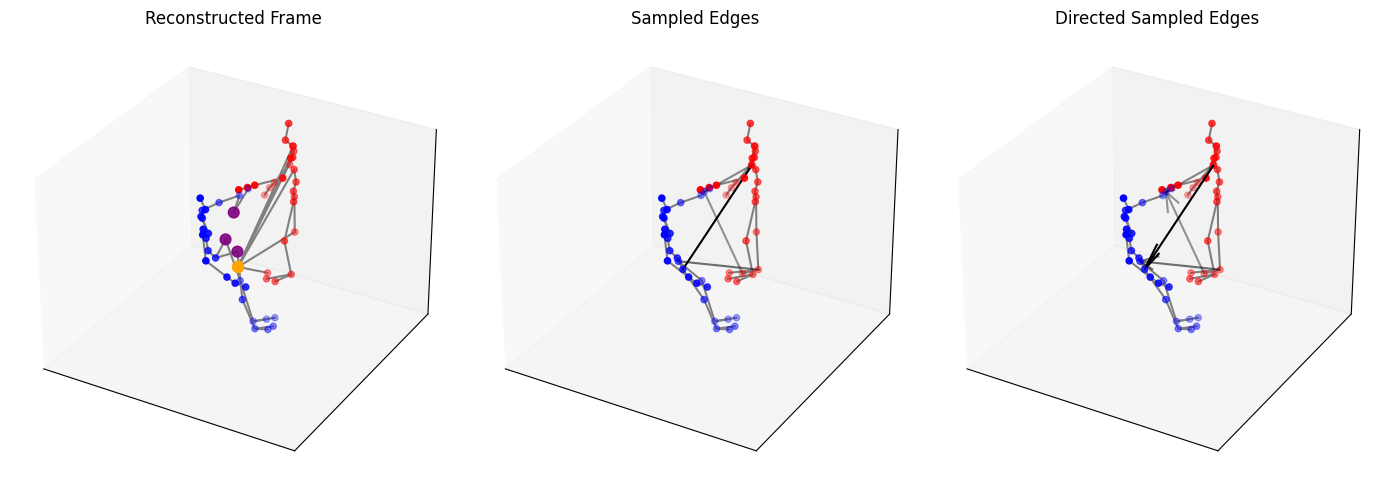

In [65]:
fig = plt.figure(figsize=(14, 6))

# Plotting reconstructed frame
ax1 = fig.add_subplot(131, projection="3d")
ax1.set_title('Reconstructed Frame')
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

ax1.scatter(recon_output[:n_joints, 0], recon_output[:n_joints, 1], recon_output[:n_joints, 2], color='orange', s=60, alpha=0.9)
ax1.scatter(recon_output[n_joints:, 0], recon_output[n_joints:, 1], recon_output[n_joints:, 2], color='purple', s=60, alpha=0.9)

dancers_no_rec = np.array(list(set(np.arange(joint_poses[0].shape[1])) - set(sampled_joints)))
ax1.scatter(joint_poses[choreo_idx][frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 2], joint_poses[choreo_idx][frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 0], \
            -joint_poses[choreo_idx][frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 1], color='red')
ax1.scatter(joint_poses[choreo_idx][frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 2], joint_poses[choreo_idx][frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 0], \
            -joint_poses[choreo_idx][frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 1], color='blue')

for (start, end) in skeletons:
    if start in sampled_joints:
        xs_0 = recon_output[edge_mapping[start], 0]
        ys_0 = recon_output[edge_mapping[start], 1]
        zs_0 = recon_output[edge_mapping[start], 2]
    else:
        xs_0 = joint_poses[choreo_idx][frame, start, 2]
        ys_0 = joint_poses[choreo_idx][frame, start, 0]
        zs_0 = -joint_poses[choreo_idx][frame, start, 1]
    
    if end in sampled_joints:
        xs_1 = recon_output[edge_mapping[end], 0]
        ys_1 = recon_output[edge_mapping[end], 1]
        zs_1 = recon_output[edge_mapping[end], 2]
    else:
        xs_1 = joint_poses[choreo_idx][frame, end, 2]
        ys_1 = joint_poses[choreo_idx][frame, end, 0]
        zs_1 = -joint_poses[choreo_idx][frame, end, 1]
    
    xs = [xs_0, xs_1]
    ys = [ys_0, ys_1]
    zs = [zs_0, zs_1]
    ax1.plot(xs, ys, zs, color='grey')

# Plotting sampled edges
ax2 = fig.add_subplot(132, projection="3d")
ax2.set_title('Sampled Edges')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

ax2.scatter(joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 2], joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 0], \
            -joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 1], color='red')
ax2.scatter(joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 2], joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 0], \
            -joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 1], color='blue')

for (start, end) in skeletons:
    xs = [joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, end, 2]]
    ys = [joint_poses[choreo_idx][frame, start, 0], joint_poses[choreo_idx][frame, end, 0]]
    zs = [-joint_poses[choreo_idx][frame, start, 1], -joint_poses[choreo_idx][frame, end, 1]]
    ax2.plot(xs, ys, zs, color='grey')

y_min = torch.min(y[edge_index_classes, chosen_edge_type])
y_max = torch.max(y[edge_index_classes, chosen_edge_type])
alphas = 0.4 + 0.6 * (y[edge_index_classes, chosen_edge_type] - y_min)/(y_max - y_min)
for i, (start, end) in enumerate(edge_index_samp.t()):
    alpha = alphas[i].cpu().detach().item()
    
    xs = [joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, end, 2]]
    ys = [joint_poses[choreo_idx][frame, start, 0], joint_poses[choreo_idx][frame, end, 0]]
    zs = [-joint_poses[choreo_idx][frame, start, 1], -joint_poses[choreo_idx][frame, end, 1]]
    
    ax2.plot(xs, ys, zs, color='black', alpha=alpha)
    
# Plotting directed sampled edges
ax3 = fig.add_subplot(133, projection="3d")
ax3.set_title('Directed Sampled Edges')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_zlim([-1, 1])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])

ax3.scatter(joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 2], joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 0], \
            -joint_poses[choreo_idx][frame, :int(joint_poses[0].shape[1]/2), 1], color='red')
ax3.scatter(joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 2], joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 0], \
            -joint_poses[choreo_idx][frame, int(joint_poses[0].shape[1]/2):, 1], color='blue')

for (start, end) in skeletons:
    xs = [joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, end, 2]]
    ys = [joint_poses[choreo_idx][frame, start, 0], joint_poses[choreo_idx][frame, end, 0]]
    zs = [-joint_poses[choreo_idx][frame, start, 1], -joint_poses[choreo_idx][frame, end, 1]]
    ax3.plot(xs, ys, zs, color='grey')

for i, (start, end) in enumerate(edge_index_samp.t()):
    alpha = alphas[i].cpu().detach().item()
        
    direction_vector = joint_poses[choreo_idx][frame, end] - joint_poses[choreo_idx][frame, start]
    
    ax3.quiver(joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, start, 0], -joint_poses[choreo_idx][frame, start, 1], \
               direction_vector[2], direction_vector[0], -direction_vector[1], color='black', alpha=alpha, arrow_length_ratio=0.2)

plt.tight_layout()
plt.show()

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video, display

# Define the update function for animation
def update(ani_frame):
    ax1.cla()
    
    # Original sequence
    ax1.set_title('Original Sequence')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    
    recon_output = recon_list[ani_frame]
    
    ax1.scatter(recon_output[:n_joints, 0], recon_output[:n_joints, 1], recon_output[:n_joints, 2], color='orange', s=60, alpha=0.9)
    ax1.scatter(recon_output[n_joints:, 0], recon_output[n_joints:, 1], recon_output[n_joints:, 2], color='purple', s=60, alpha=0.9)
    
    dancers_no_rec = np.array(list(set(np.arange(joint_poses[0].shape[1])) - set(sampled_joints)))
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 2], 
                joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 0], 
                -joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 1], color='red')
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 2], 
                joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 0], 
                -joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 1], color='blue')
    
    for (start, end) in skeletons:
        if start in sampled_joints:
            xs_0 = recon_output[edge_mapping[start], 0]
            ys_0 = recon_output[edge_mapping[start], 1]
            zs_0 = recon_output[edge_mapping[start], 2]
        else:
            xs_0 = joint_poses[choreo_idx][frame+ani_frame, start, 2]
            ys_0 = joint_poses[choreo_idx][frame+ani_frame, start, 0]
            zs_0 = -joint_poses[choreo_idx][frame+ani_frame, start, 1]
        
        if end in sampled_joints:
            xs_1 = recon_output[edge_mapping[end], 0]
            ys_1 = recon_output[edge_mapping[end], 1]
            zs_1 = recon_output[edge_mapping[end], 2]
        else:
            xs_1 = joint_poses[choreo_idx][frame+ani_frame, end, 2]
            ys_1 = joint_poses[choreo_idx][frame+ani_frame, end, 0]
            zs_1 = -joint_poses[choreo_idx][frame+ani_frame, end, 1]
        
        xs = [xs_0, xs_1]
        ys = [ys_0, ys_1]
        zs = [zs_0, zs_1]
        ax1.plot(xs, ys, zs, color='grey')


fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection="3d")

# Create animation
ani = FuncAnimation(fig, update, frames=len(recon_list), repeat=True, interval=100)
ani = ani.to_jshtml()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani}
    </div>
</div>
"""))

plt.close()

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video, display

# Define the update function for animation
def update(ani_frame):
    ax1.cla()
    
    # Reconstructed sequence
    ax1.set_title('Reconstructed Sequence')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    
    recon_output = recon_list[ani_frame]
    
    ax1.scatter(recon_output[:n_joints, 0], recon_output[:n_joints, 1], recon_output[:n_joints, 2], color='orange', s=60, alpha=0.9)
    ax1.scatter(recon_output[n_joints:, 0], recon_output[n_joints:, 1], recon_output[n_joints:, 2], color='purple', s=60, alpha=0.9)
    
    dancers_no_rec = np.array(list(set(np.arange(joint_poses[0].shape[1])) - set(sampled_joints)))
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 2], 
                joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 0], 
                -joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[:int(len(dancers_no_rec)/2)], 1], color='red')
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 2], 
                joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 0], 
                -joint_poses[choreo_idx][frame+ani_frame, dancers_no_rec[int(len(dancers_no_rec)/2):], 1], color='blue')
    
    for (start, end) in skeletons:
        if start in sampled_joints:
            xs_0 = recon_output[edge_mapping[start], 0]
            ys_0 = recon_output[edge_mapping[start], 1]
            zs_0 = recon_output[edge_mapping[start], 2]
        else:
            xs_0 = joint_poses[choreo_idx][frame+ani_frame, start, 2]
            ys_0 = joint_poses[choreo_idx][frame+ani_frame, start, 0]
            zs_0 = -joint_poses[choreo_idx][frame+ani_frame, start, 1]
        
        if end in sampled_joints:
            xs_1 = recon_output[edge_mapping[end], 0]
            ys_1 = recon_output[edge_mapping[end], 1]
            zs_1 = recon_output[edge_mapping[end], 2]
        else:
            xs_1 = joint_poses[choreo_idx][frame+ani_frame, end, 2]
            ys_1 = joint_poses[choreo_idx][frame+ani_frame, end, 0]
            zs_1 = -joint_poses[choreo_idx][frame+ani_frame, end, 1]
        
        xs = [xs_0, xs_1]
        ys = [ys_0, ys_1]
        zs = [zs_0, zs_1]
        ax1.plot(xs, ys, zs, color='grey')


fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection="3d")

# Create animation
ani = FuncAnimation(fig, update, frames=len(recon_list), repeat=True, interval=100)
ani = ani.to_jshtml()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani}
    </div>
</div>
"""))

plt.close()

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video, display

# Define the update function for animation
def update(ani_frame):
    ax1.cla()
    
    # Sampled edges
    ax1.set_title('Sampled Edges')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])

    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 2], 
                joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 0], 
                -joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 1], color='red')
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 2], 
                joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 0], 
                -joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 1], color='blue')

    for (start, end) in skeletons:
        xs = [joint_poses[choreo_idx][frame+ani_frame, start, 2], joint_poses[choreo_idx][frame+ani_frame, end, 2]]
        ys = [joint_poses[choreo_idx][frame+ani_frame, start, 0], joint_poses[choreo_idx][frame+ani_frame, end, 0]]
        zs = [-joint_poses[choreo_idx][frame+ani_frame, start, 1], -joint_poses[choreo_idx][frame+ani_frame, end, 1]]
        ax1.plot(xs, ys, zs, color='grey')

    for i, (start, end) in enumerate(edge_index_samp.t()):
        alpha = alphas[i].cpu().detach().item()
        
        xs = [joint_poses[choreo_idx][frame+ani_frame, start, 2], joint_poses[choreo_idx][frame+ani_frame, end, 2]]
        ys = [joint_poses[choreo_idx][frame+ani_frame, start, 0], joint_poses[choreo_idx][frame+ani_frame, end, 0]]
        zs = [-joint_poses[choreo_idx][frame+ani_frame, start, 1], -joint_poses[choreo_idx][frame+ani_frame, end, 1]]
        
        ax1.plot(xs, ys, zs, color='black', alpha=alpha)


fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection="3d")

# Create animation
ani = FuncAnimation(fig, update, frames=len(recon_list), repeat=True, interval=100)
ani = ani.to_jshtml()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani}
    </div>
</div>
"""))

plt.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video, display

# Define the update function for animation
def update(ani_frame):
    ax1.cla()
    
    # Directed sampled edges
    ax1.set_title('Directed Sampled Edges')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 2], joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 0], \
                -joint_poses[choreo_idx][frame+ani_frame, :int(joint_poses[0].shape[1]/2), 1], color='red')
    ax1.scatter(joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 2], joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 0], \
                -joint_poses[choreo_idx][frame+ani_frame, int(joint_poses[0].shape[1]/2):, 1], color='blue')
    
    for (start, end) in skeletons:
        xs = [joint_poses[choreo_idx][frame+ani_frame, start, 2], joint_poses[choreo_idx][frame+ani_frame, end, 2]]
        ys = [joint_poses[choreo_idx][frame+ani_frame, start, 0], joint_poses[choreo_idx][frame+ani_frame, end, 0]]
        zs = [-joint_poses[choreo_idx][frame+ani_frame, start, 1], -joint_poses[choreo_idx][frame+ani_frame, end, 1]]
        ax1.plot(xs, ys, zs, color='grey')
    
    for i, (start, end) in enumerate(edge_index_samp.t()):
        alpha = alphas[i].cpu().detach().item()
            
        direction_vector = joint_poses[choreo_idx][frame+ani_frame, end] - joint_poses[choreo_idx][frame+ani_frame, start]
        
        ax1.quiver(joint_poses[choreo_idx][frame+ani_frame, start, 2], joint_poses[choreo_idx][frame+ani_frame, start, 0], -joint_poses[choreo_idx][frame+ani_frame, start, 1], \
                   direction_vector[2], direction_vector[0], -direction_vector[1], color='black', alpha=alpha, arrow_length_ratio=0.2)


fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111, projection="3d")

# Create animation
ani = FuncAnimation(fig, update, frames=len(recon_list), repeat=True, interval=100)
ani = ani.to_jshtml()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani}
    </div>
</div>
"""))

plt.close()